# Prima prova di neural network

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import json
import sys
import time
from importlib import reload

In [2]:
COLOR = False
SMALL = True
LETTERS_LABEL = ['h', 's', 'u']
COLORS_LABEL = ['b', 'g', 'r']

Prendo i dati, li leggo e li splitto

In [3]:
with open('../data/images/data.json', 'r') as f:
    train = json.load(f)
labels = set()
train_img = []
y = []
for img_name, label in tqdm(train.items()):

    # addestro le lettere per vedere i colori come none
    # idem la nn per i colori, deve vedere le lettere come none
    if COLOR and label in LETTERS_LABEL:
        label = 'none'
    elif not COLOR and label in COLORS_LABEL:
        label = 'none'

    labels.add(label)


    y.append(label)
    image_path = '../data/' + str(img_name)
    img = imread(image_path, as_gray=not COLOR)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    train_img.append(img)


numLabel = len(labels)
# converting the list to numpy array
X = np.array(train_img)
y = np.array(y)

  0%|          | 0/276 [00:00<?, ?it/s]

One hot encoding o Label encoding

In [4]:
oneHot = False

In [5]:
if oneHot:
    one = preprocessing.OneHotEncoder()
    y = one.fit_transform(y.reshape(-1,1)).toarray()
    pickle.dump(one, open(f'saves/oneHotEncoder{"Color" if COLOR else ""}.pickle', 'wb'))
else:
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    # print the classes
    print(le.classes_)
    pickle.dump(le, open(f'saves/labelEncoder{"Color" if COLOR else ""}.pickle', 'wb'))

['h' 'none' 's' 'u']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)


# converting the target into torch format
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
X_train  = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

# shape of training data
X_train.shape, y_train.shape

(torch.Size([234, 28, 28]), torch.Size([234]))

In [7]:
if COLOR:
    # inverto gli assi, l'rgb non e' sui singoli pixel ma diviso in tre canali diversi di immagini con pixel monovalore
    X_test = X_test.permute(0, 3, 2, 1)
    X_train = X_train.permute(0, 3, 2, 1)
else:
    # aggiungo la dimensione canale(colore), che qui e' solo una
    X_train = X_train.unsqueeze(1)
    X_test = X_test.unsqueeze(1)
y_test = y_test.type(torch.LongTensor)
y_train = y_train.type(torch.LongTensor)

In [8]:
test = TensorDataset(X_test, y_test)
train = TensorDataset(X_train, y_train)

creo i batch, randomizzando i dati, con un dataloader

In [9]:
batch_size = 50

# Create data loaders.
test = DataLoader(test, batch_size=batch_size, shuffle=True)
train = DataLoader(train, batch_size=batch_size, shuffle=True)

for X, y in test:
    print(f"Shape of X : {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X : torch.Size([42, 1, 28, 28])
Shape of y: torch.Size([42]) torch.int64


# creo la neural network

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [71]:
# moved definition to a second file, so I can dump the model and reload it from a third file
if SMALL:
    import SmallCnn
    reload(SmallCnn)
    from SmallCnn import NeuralNetwork
else:
    import CNN
    reload(CNN)
    from CNN import NeuralNetwork

In [72]:
model = NeuralNetwork(numLabel=numLabel, not_color= not COLOR).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 32, kernel_size=(5, 5), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [73]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()

In [74]:
def trainf(dataloader, model, loss_fn, optimizer, print=True):
    global best_model
    best_loss = float("inf")
    size = len(dataloader.dataset)
    #model.double()
    model.train()
    for batch , (X, Y) in tqdm(enumerate(dataloader), leave=False, total=len(dataloader), position=1, file=sys.stdout):
        X, Y = X.to(device), Y.to(device)
        loss = float("inf")
        optimizer.zero_grad()
        # Compute prediction error
        #output = torch.argmax(X, dim=1).float()
        pred = model(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        # Backpropagation
        optimizer.step()

        if loss < best_loss:
            best_loss = loss
            best_model = deepcopy(model)

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_losses.append(loss)
            if print:
                tqdm.write(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [75]:
def testf(dataloader, model, loss_fn, print=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            gas_loss = [([],[]) for _ in range(5)]
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            loss = loss_fn(pred, Y).item()
            test_loss += loss
            if batch % 100 == 0:
                val_losses.append(loss)
    test_loss /= num_batches * batch_size
    if print:
        tqdm.write(f"Test Error:  Avg loss: {test_loss:>8f} \n")


In [78]:
epochs = 100
val_losses = []
train_losses = []
best_model = None
for t in trange(epochs, file=sys.stdout):
    trainf(train, model, loss_fn, optimizer, print=False)
    testf(test, model, loss_fn, print=False)
torch.save(model.state_dict(), f'saves/nn{"Color" if COLOR else ""}{"Small" if SMALL else ""}.torch')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

len(train_losses)=100


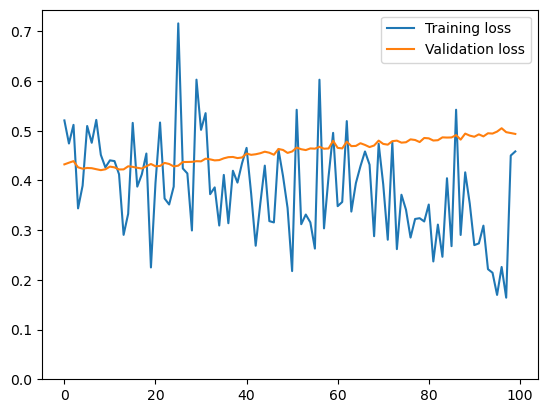

In [79]:
print(f'{len(train_losses)=}')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
# start y from 0
plt.ylim(bottom=0)
plt.show()

In [56]:
true = 0
false = 0

model.eval()
with torch.no_grad():
    for x, y in zip(X_test, y_test):
        if COLOR:
            x = x.permute(0, 3, 2, 1)
        else:
            x = x.unsqueeze(1)
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()[0]
        if y_pred == y:
            true += 1
        else:
            false += 1

print('test data')
print(f'{true=}')
print(f'{false=}')
print(f'{true/(true+false)=}')
with torch.no_grad():
    for x, y in zip(X_train, y_train):
        if COLOR:
            x = x.permute(0, 3, 2, 1)
        else:
            x = x.unsqueeze(1)
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()[0]
        if y_pred == y:
            true += 1
        else:
            false += 1

print('train data')
print(f'{true=}')
print(f'{false=}')
print(f'{true/(true+false)=}')

test data
true=38
false=4
true/(true+false)=0.9047619047619048
train data
true=233
false=43
true/(true+false)=0.8442028985507246
